# Bias / Variance / Irreducible Error

## Bias

This part of the generalisation error is due to wrong assumptions, such as assuming that data is linear when it is actually quandratic. A high-bias model is most like to underfit the training data. (High MSE in training data)


## Variance

This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data. (Low MSE in Training Data, High MSE in Validation/Test Data)



## Sweet Spot
The goal is optimise the sweet spot with reasonable bias/variance, preferablly low bias, low variance. However, a low bias typically results in high varance (overfit) and viceversa (underfit).

The ways in optimising are:
- Regularisation - to reduce overfit by adding a paramer against weights
- Boosting (Emsemble)
- Bagging (random forest)


## Irreducible Error
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up data.

Bias and Variance is always a trade off between model complexity (more complex less bias more variance.)

# Regularisation

There is a good article on this via sklearn: https://scikit-learn.org/stable/modules/linear_model.html

**Note** 

- Regularisation term is only added to cost function during training.
- Y-intercept is NOT included


# Ridge Regression
Ridge Regrssion (Tikhnov regularisation) is a regularised version of linear regression. Forces model not only fit but keep the weights as small as possible.

Sum of all weight^2 with a hyper parameter (lambda which controlls how much regularisation is applied. if 0 then typical linear regression). 

Higher the lambda the flatter the slope, therefore reducing variance increasiong bias. The slope asymptote to zero as alpha (or lambda) gets bigger.

The ridge regession will also help solve data with small data set but numerous features.

## Cost function
**note** i start from 1 for the regularisation term

$j(\theta) = MSE(\theta) + \frac{\lambda\sum_{i=1}^n(\theta^2)}{2}$

where:

$sum(\theta^2)$ is also know as L2 norm

## Cholesky's closed-form solution

$\hat{\theta} = (X^TX + \alpha A)^-1X^T y$


Of course, we can also use gradient descent with L2 panelty as well

In [4]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge, SGDRegressor

X, y, coef = make_regression(n_features = 1, coef = True, noise = 10, bias = 5)

sgd_reg1 = SGDRegressor(alpha = 0.01, penalty = "l2") # note sometimes lambda is referred as alpha. 
sgd_reg1.fit(X, y)

sgd_reg2 = SGDRegressor(alpha = 0.1, penalty = "l2") # note sometimes lambda is referred as alpha. 
sgd_reg2.fit(X, y)

ridge_reg1 = Ridge(alpha = 1, solver = "cholesky")
ridge_reg1.fit(X, y)


Ridge(alpha=1, solver='cholesky')

41.56958430665433 38.386439409638186 41.58064893648367


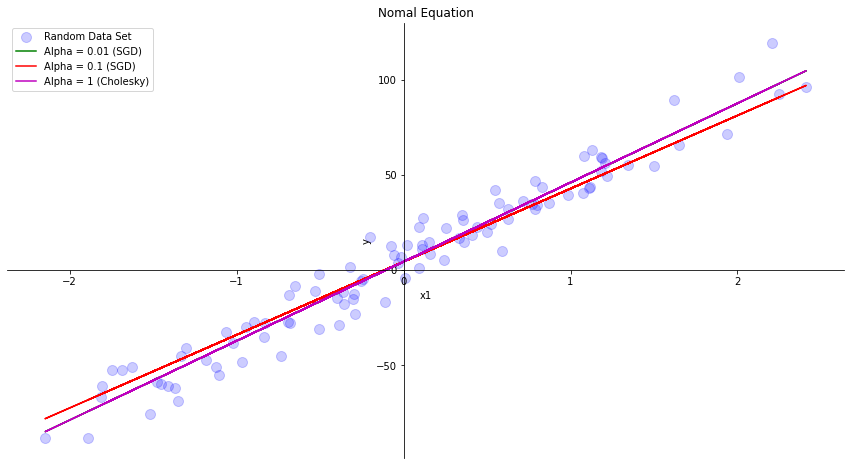

In [5]:
import numpy as np
from matplotlib import pyplot as plt

##### weights mean, note that the higher alpha values is flatter
print(np.mean(sgd_reg1.coef_), np.mean(sgd_reg2.coef_), np.mean(ridge_reg1.coef_))

y_pred1 = sgd_reg1.predict(X)
y_pred2 = sgd_reg2.predict(X)
y_pred3 = ridge_reg1.predict(X)

### Visualise regression line.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((15, 8))
ax.scatter(X, y, c = 'b', s = 100, alpha = 0.2, label = "Random Data Set")
ax.plot(X, y_pred1, c = 'g', label = "Alpha = 0.01 (SGD)")
ax.plot(X, y_pred2, c = 'r', label = "Alpha = 0.1 (SGD)")
ax.plot(X, y_pred3, c = 'm', label = "Alpha = 1 (Cholesky)")
ax.set_title("Nomal Equation")

ax.spines['top'].set_color('none')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')

#plt.xlim(-np.pi, np.pi)

plt.xlabel('x1')
plt.ylabel('y')
ax.legend()

# Lasso Regrssion

*Least absolute shrinkage and selection operator regression*, using l1 norm instead of l2 norm. Tends to eliminate less important features, setting weight to 0.

## Cost function
$j(\theta) = MSE(\theta) + \lambda\sum(abs(\theta))$


### Elastic Net
j(theta) = MSE(theta) + r*alpha* sum(abs(theta)) + (1-r)/2 * alpha * sum(theta^2)

Note that ridge regression is a useful technique if as it automatically reduce features, however if there are features of importance it would be better to use Lasso or Elastic Net

# Early Stopping

This is a different way to regularise iterative learning algorithms, by stop Gradient descent as soon as validation error reaches minimum. With stochastic and mini-batch the curves will not be smooth, to check minimum, may use a patience paramter to ensure the model error has reached minimum for sometime.

In [27]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y, coef = make_regression(n_features = 100, n_samples = 10000, coef = True, noise = 10, bias = 5)

# train, validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# pipline to perform polinomial transformation then scalling
poly_scaler = Pipeline([
    ("PolynomialFeatures", PolynomialFeatures(degree = 2, include_bias = True)),
    ("StandardScaler", StandardScaler())
])

# used for training /validating model
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)


# stochastic gradient descent regressor, when warm_start is true fix method will continue from where it left of when training.
sgd_reg = SGDRegressor(n_iter_no_change = 1, warm_start = True, penalty = None, learning_rate = "constant", eta0 = 0.0005)


# initialise errors
min_val_error = float("inf")

best_epoch = None
best_model = None

train_errors = []
val_errors = []

for epoch in range(1000):
    m  = sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_error = mean_squared_error(sgd_reg.predict(X_train_poly_scaled), y_train)
    val_error = mean_squared_error(y_val_predict, y_val)
    train_errors.append(train_error)
    val_errors.append(val_error)

    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        print(sgd_reg.coef_)

[  0.          48.51683095 -22.50970875 ... -96.93081312   9.91092886
 -39.58432472]


1000

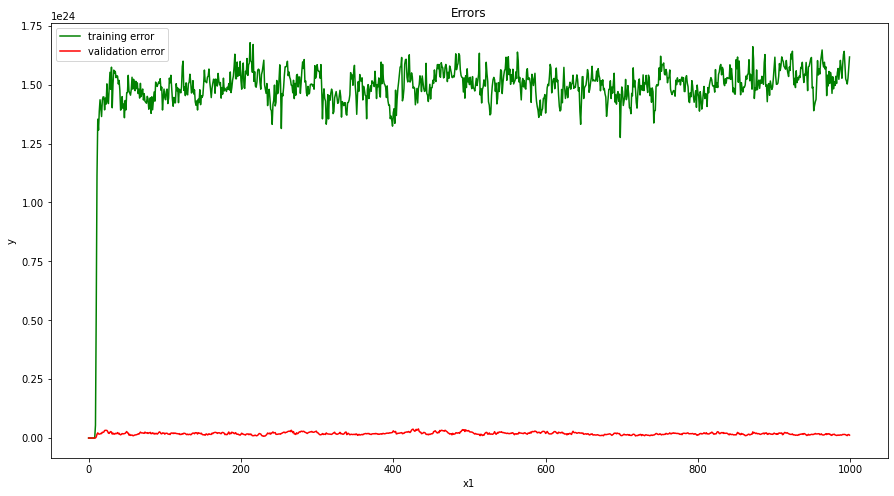

In [25]:
x = range(1000)

### Visualise regression line.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((15, 8))


ax.plot(x, train_errors, c = 'g', label = "training error")
ax.plot(x, val_errors, c = 'r', label = "validation error")

ax.set_title("Errors")

plt.xlabel('x1')
plt.ylabel('y')
ax.legend()

len(range(1000))


100